<a href="https://colab.research.google.com/github/elijahcw-git/Capstone/blob/main/Crime_Hotspot_Prediction_ARIMA_Area_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install category_encoders


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Import dataset:

crime_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/crime_clean.csv')
print(crime_df.shape)

(2883802, 26)


In [4]:
print(f"Dataset shape :{crime_df.shape}\n")


missing_values = crime_df.isnull().sum()
percentage_missing = (missing_values / len(crime_df)) * 100
unique_values = crime_df.nunique()
summary_df = print(pd.DataFrame({'Data_type': crime_df.dtypes,'Missing': missing_values, '%_Missing': percentage_missing, 'Unique_values': unique_values}))

print(summary_df)

Dataset shape :(2883802, 26)

                     Data_type  Missing  %_Missing  Unique_values
DR_NO                    int64        0        0.0        2555000
Date_Rptd               object        0        0.0           5129
DATE_OCC                object        0        0.0           5111
TIME_OCC                 int64        0        0.0           1439
AREA                     int64        0        0.0             21
AREA_NAME               object        0        0.0             21
Rpt_Dist_No              int64        0        0.0           1302
Part_1-2                 int64        0        0.0              2
Crm_Cd                   int64        0        0.0            144
Crm_Cd_Desc             object        0        0.0            144
Vict_Age               float64        0        0.0             99
Vict_Sex                object        0        0.0              3
Vict_Descent            object        0        0.0             21
LOCATION                object        0       

In [5]:
crime_df['DATE_OCC'] = pd.to_datetime(crime_df['DATE_OCC'])
crime_df.head(5)

,DR_NO,Date_Rptd,DATE_OCC,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,...,Avg_Temp,Avg_Dewpoint,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin
0,1307355,02/20/2010 12:00:00 AM,2010-02-20,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,56.1,47.5,73.2,9.7,29.8,0.0,0,Violations and Restraining Orders,7,Hispanic/Latin/Mexican
1,100100638,02/20/2010 12:00:00 AM,2010-02-20,100,1,Central,164,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,56.1,47.5,73.2,9.7,29.8,0.0,0,Vandalism and Property Damage,6,Other
2,100100639,02/20/2010 12:00:00 AM,2010-02-20,230,1,Central,164,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,56.1,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican
3,100106650,02/20/2010 12:00:00 AM,2010-02-20,45,1,Central,155,2,624,BATTERY - SIMPLE ASSAULT,...,56.1,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black
4,100106654,02/20/2010 12:00:00 AM,2010-02-20,1130,1,Central,146,2,946,OTHER MISCELLANEOUS CRIME,...,56.1,47.5,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Hispanic/Latin/Mexican


In [6]:
crime_df.set_index('DATE_OCC', inplace=True)

In [7]:
# Convert the following into categorical

crime_df['AREA_NAME'] = crime_df['AREA_NAME'].astype('category')

In [8]:
crime_df['Crime_Incidence'] = crime_df.groupby(['AREA_NAME', 'DATE_OCC'])['AREA_NAME'].transform('count')

In [9]:
# area_mapping = {
#    'Central': 'Central_Bureau', 'Hollenbeck': 'Central_Bureau', 'Newton': 'Central_Bureau', 'Northeast': 'Central_Bureau', 'Rampart': 'Central_Bureau',
#    '77th Street': 'South_Bureau', 'Harbor': 'South_Bureau', 'Southeast': 'South_Bureau', 'Southwest': 'South_Bureau',
#    'Hollywood': 'West_Bureau', 'Olympic': 'West_Bureau', 'Pacific': 'West_Bureau', 'West Los Angeles': 'West_Bureau', 'Wilshire': 'West_Bureau',
#    'Devonshire': 'Valley_Bureau', 'Foothill': 'Valley_Bureau', 'Mission': 'Valley_Bureau', 'N Hollywood': 'Valley_Bureau', 'Topanga': 'Valley_Bureau', 'Van Nuys': 'Valley_Bureau', 'West Valley': 'Valley_Bureau',
#}
# Creating the new variable, BUREAU.

# crime_df['BUREAU'] = crime_df['AREA_NAME'].map(area_mapping)

In [10]:
crime_df.head(20)

,DR_NO,Date_Rptd,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,Vict_Age,...,Avg_Dewpoint,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin,Crime_Incidence
DATE_OCC,,,,,,,,,,,,,,,,,,,,,
2010-02-20,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,48.0,...,47.5,73.2,9.7,29.8,0.0,0,Violations and Restraining Orders,7,Hispanic/Latin/Mexican,38
2010-02-20,100100638,02/20/2010 12:00:00 AM,100,1,Central,164,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0.0,...,47.5,73.2,9.7,29.8,0.0,0,Vandalism and Property Damage,6,Other,16
2010-02-20,100100639,02/20/2010 12:00:00 AM,230,1,Central,164,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,25.0,...,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,16
2010-02-20,100106650,02/20/2010 12:00:00 AM,45,1,Central,155,2,624,BATTERY - SIMPLE ASSAULT,53.0,...,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black,16
2010-02-20,100106654,02/20/2010 12:00:00 AM,1130,1,Central,146,2,946,OTHER MISCELLANEOUS CRIME,18.0,...,47.5,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Hispanic/Latin/Mexican,16
2010-02-20,100106660,02/20/2010 12:00:00 AM,1200,1,Central,165,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",46.0,...,47.5,73.2,9.7,29.8,0.0,0,Theft and Burglary,5,Other,16
2010-02-20,100106674,02/20/2010 12:00:00 AM,1645,1,Central,182,2,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,21.0,...,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,16
2010-02-20,100106675,02/20/2010 12:00:00 AM,1100,1,Central,192,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,49.0,...,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,16
2010-02-20,100106677,02/20/2010 12:00:00 AM,1400,1,Central,161,1,440,THEFT PLAIN - PETTY ($950 & UNDER),35.0,...,47.5,73.2,9.7,29.8,0.0,0,Theft and Burglary,5,Black,16


In [11]:
crime_df.shape

(2883802, 26)

In [12]:
# Convert the following into categorical

# crime_df['BUREAU'] = crime_df['BUREAU'].astype('category')

In [13]:
crime_df['AREA_NAME'].value_counts()

77th Street    186392
Southwest      184073
Central        156659
Pacific        150005
N Hollywood    147519
Southeast      145151
Hollywood      142079
Northeast      139159
Van Nuys       137837
Newton         133213
Mission        132084
Rampart        130369
Wilshire       129314
West LA        127442
West Valley    126732
Olympic        126603
Topanga        125854
Devonshire     125420
Harbor         124890
Hollenbeck     110319
Foothill       102688
Name: AREA_NAME, dtype: int64

<Figure size 1200x600 with 0 Axes>

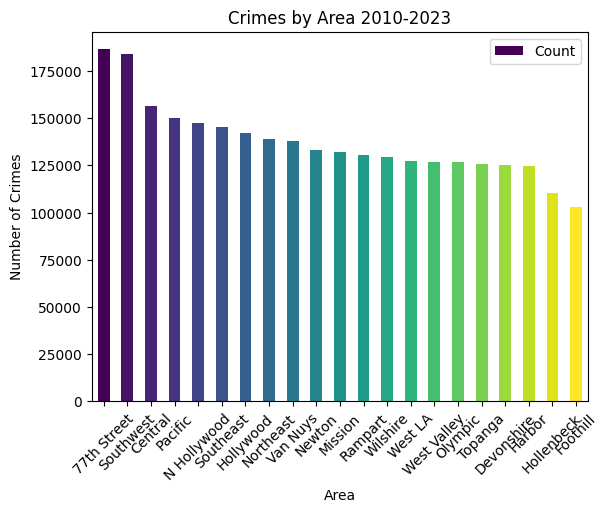

In [14]:
# Group by AREA and count the number of crimes
crimes_by_area = crime_df.groupby('AREA_NAME')['DR_NO'].count().reset_index(name='Count')


# Sort by crime count
crimes_by_area = crimes_by_area.sort_values('Count', ascending=False)

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(crimes_by_area)))

# Create a bar chart
plt.figure(figsize=(12, 6))
crimes_by_area.plot(kind='bar', x='AREA_NAME', y='Count', color=colors)

# Add labels and title
plt.title('Crimes by Area 2010-2023')
plt.xlabel('Area')
plt.ylabel('Number of Crimes')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the bar chart
plt.show()




In [15]:
# crime_df.to_csv('crime_bureau.csv', index=False)

In [16]:
# To split crime_df into four separate datasets based on bureau category.

split_datasets = {}

categories = crime_df['AREA_NAME'].unique()
for category in categories:
  split_datasets[category] = crime_df[crime_df['AREA_NAME'] ==category]

SeventhStreet_dataset = split_datasets['77th Street']
Southwest_dataset = split_datasets['Southwest']
Central_dataset = split_datasets['Central']
Pacific_dataset = split_datasets['Pacific']
N_Hollywood_dataset = split_datasets['N Hollywood']
Southeast_dataset = split_datasets['Southeast']
Hollywood_dataset = split_datasets['Hollywood']
Northeast_dataset = split_datasets['Northeast']
Van_Nuys_dataset = split_datasets['Van Nuys']
Newton_dataset = split_datasets['Newton']
Mission_dataset = split_datasets['Mission']
Rampart_dataset = split_datasets['Rampart']
Wilshire_dataset = split_datasets['Wilshire']
West_LA_dataset = split_datasets['West LA']
West_Valley_dataset = split_datasets['West Valley']
Olympic_dataset = split_datasets['Olympic']
Topanga_dataset = split_datasets['Topanga']
Devonshire_dataset = split_datasets['Devonshire']
Harbor_dataset = split_datasets['Harbor']
Hollenbeck_dataset = split_datasets['Hollenbeck']
Foothill_dataset = split_datasets['Foothill']

In [17]:
SeventhStreet_dataset.head()

,DR_NO,Date_Rptd,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,Vict_Age,...,Avg_Dewpoint,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin,Crime_Incidence
DATE_OCC,,,,,,,,,,,,,,,,,,,,,
2010-02-20,101207980,02/22/2010 12:00:00 AM,800,12,77th Street,1232,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0.0,...,47.5,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Other,74
2010-02-20,101207910,02/20/2010 12:00:00 AM,2030,12,77th Street,1269,2,946,OTHER MISCELLANEOUS CRIME,0.0,...,47.5,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Other,74
2010-02-20,101208127,02/24/2010 12:00:00 AM,1915,12,77th Street,1269,1,440,THEFT PLAIN - PETTY ($950 & UNDER),56.0,...,47.5,73.2,9.7,29.8,0.0,0,Theft and Burglary,5,Other,74
2010-02-20,101207941,02/22/2010 12:00:00 AM,2300,12,77th Street,1205,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,30.0,...,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,74
2010-02-20,101207892,02/21/2010 12:00:00 AM,1300,12,77th Street,1243,1,510,VEHICLE - STOLEN,0.0,...,47.5,73.2,9.7,29.8,0.0,0,Theft and Burglary,5,Other,74


In [18]:
crime_df.shape[0]

2883802

**Using ARIMA to Predict Crime Incidence**

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

In [20]:
!pip install pmdarima
from pmdarima.arima import auto_arima

In [21]:
from pathlib import Path
import math
from math import floor,ceil,sqrt
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import preprocessing

 **22. Full Dataset (All Areas)**

In [24]:
crime_df.head(5)

,DR_NO,Date_Rptd,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,Vict_Age,...,Avg_Dewpoint,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin,Crime_Incidence
DATE_OCC,,,,,,,,,,,,,,,,,,,,,
2010-02-20,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,48.0,...,47.5,73.2,9.7,29.8,0.0,0,Violations and Restraining Orders,7,Hispanic/Latin/Mexican,38
2010-02-20,100100638,02/20/2010 12:00:00 AM,100,1,Central,164,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0.0,...,47.5,73.2,9.7,29.8,0.0,0,Vandalism and Property Damage,6,Other,16
2010-02-20,100100639,02/20/2010 12:00:00 AM,230,1,Central,164,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,25.0,...,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,16
2010-02-20,100106650,02/20/2010 12:00:00 AM,45,1,Central,155,2,624,BATTERY - SIMPLE ASSAULT,53.0,...,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black,16
2010-02-20,100106654,02/20/2010 12:00:00 AM,1130,1,Central,146,2,946,OTHER MISCELLANEOUS CRIME,18.0,...,47.5,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Hispanic/Latin/Mexican,16


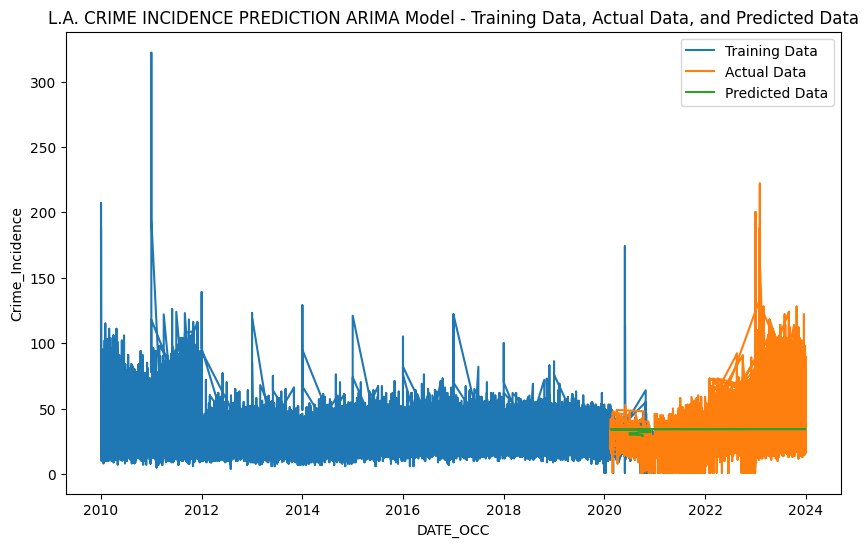

Root Mean Squared Error on Test Set: 27.570744885510575


In [34]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(crime_df) * 0.8)  # Adjust the train size as needed
train_data, test_data = crime_df[:train_size]['Crime_Incidence'], crime_df[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(crime_df.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(crime_df.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(crime_df.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('L.A. CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')

**1. ARIMA for 77th Street Area**

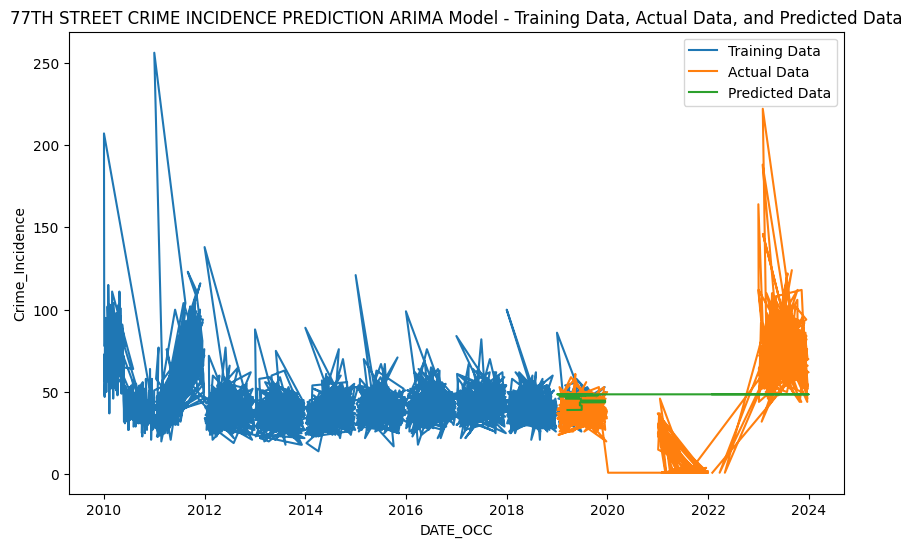

Root Mean Squared Error on Test Set: 34.639821208886715
RMSE: 34.64


In [33]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(SeventhStreet_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = SeventhStreet_dataset[:train_size]['Crime_Incidence'], SeventhStreet_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(SeventhStreet_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(SeventhStreet_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(SeventhStreet_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('77TH STREET CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**2. ARIMA for Southwest Area**

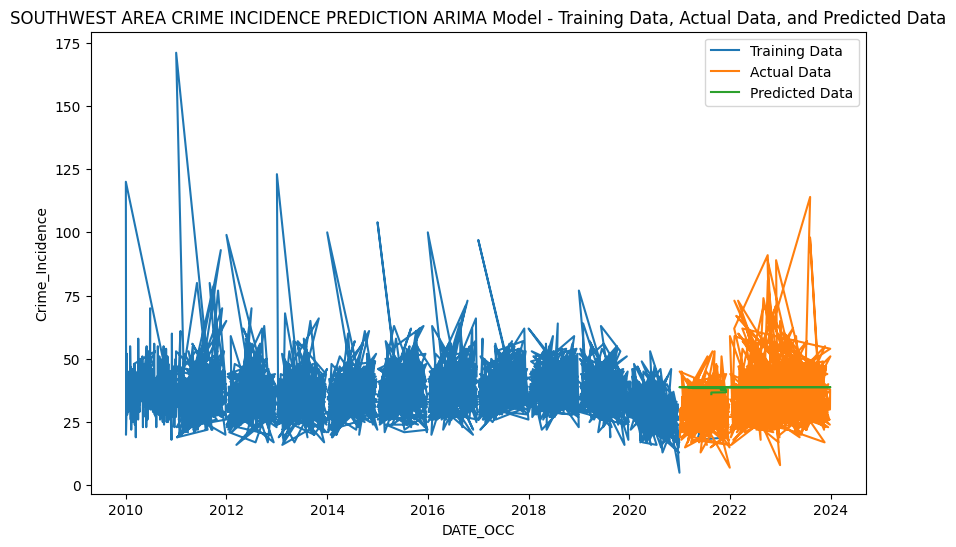

Root Mean Squared Error on Test Set: 12.197250089788925
RMSE: 12.20


In [36]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Southwest_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Southwest_dataset[:train_size]['Crime_Incidence'], Southwest_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Southwest_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Southwest_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Southwest_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('SOUTHWEST AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**3. ARIMA for Central Area**

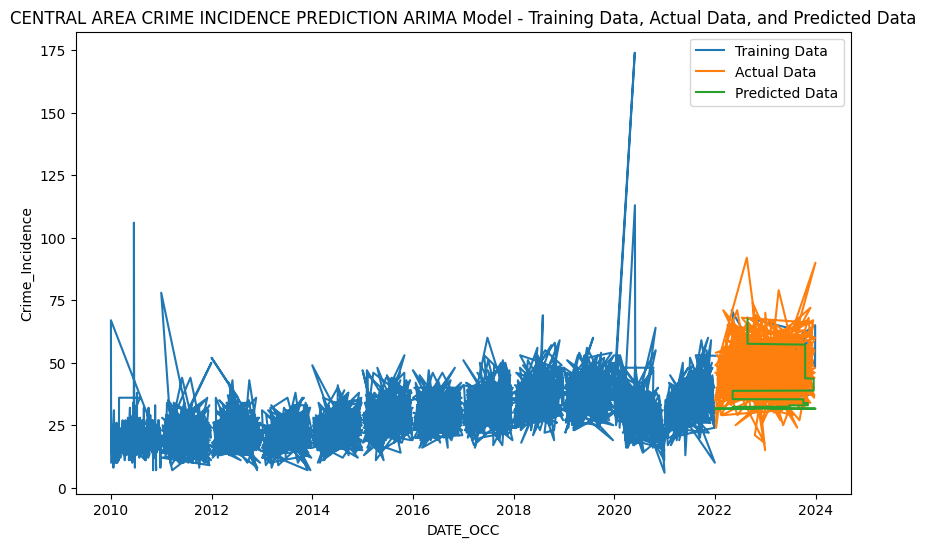

Root Mean Squared Error on Test Set: 19.532484294974946
RMSE: 19.53


In [40]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Central_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Central_dataset[:train_size]['Crime_Incidence'], Central_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Central_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Central_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Central_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('CENTRAL AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**4. ARIMA for Pacific Area**

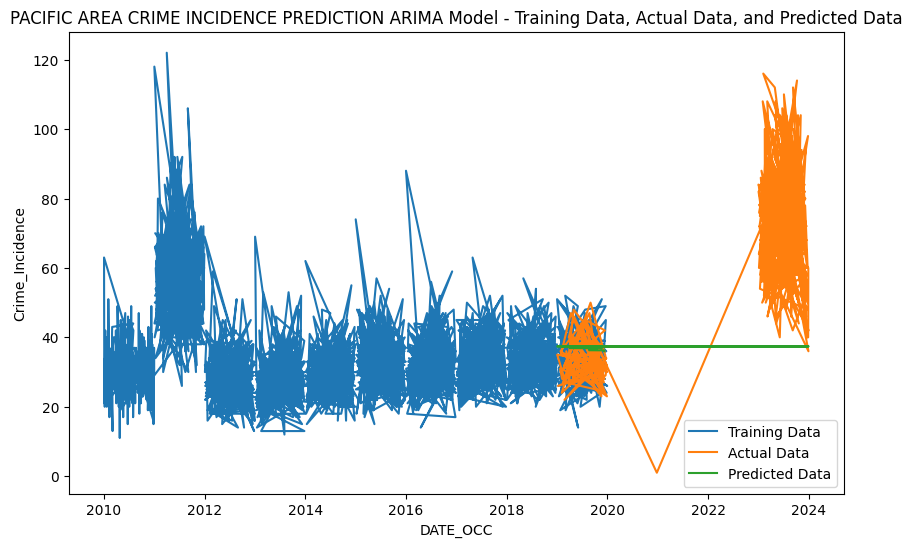

Root Mean Squared Error on Test Set: 40.33463087837938
RMSE: 40.33


In [38]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Pacific_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Pacific_dataset[:train_size]['Crime_Incidence'], Pacific_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Pacific_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Pacific_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Pacific_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('PACIFIC AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**5. ARIMA for N Hollywood Area**

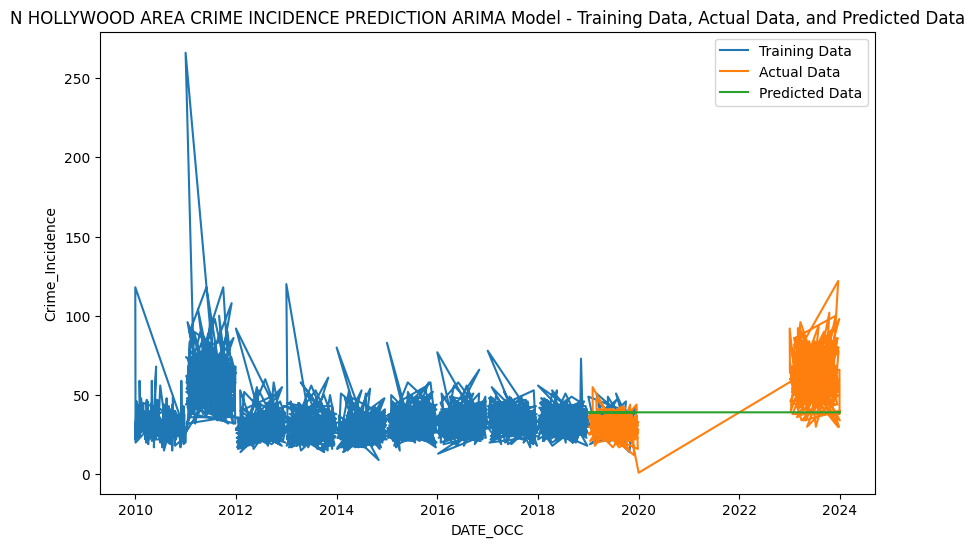

Root Mean Squared Error on Test Set: 26.14812856377553
RMSE: 26.15


In [41]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(N_Hollywood_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = N_Hollywood_dataset[:train_size]['Crime_Incidence'], N_Hollywood_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(N_Hollywood_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(N_Hollywood_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(N_Hollywood_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('N HOLLYWOOD AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**6. ARIMA for Southeast Area**

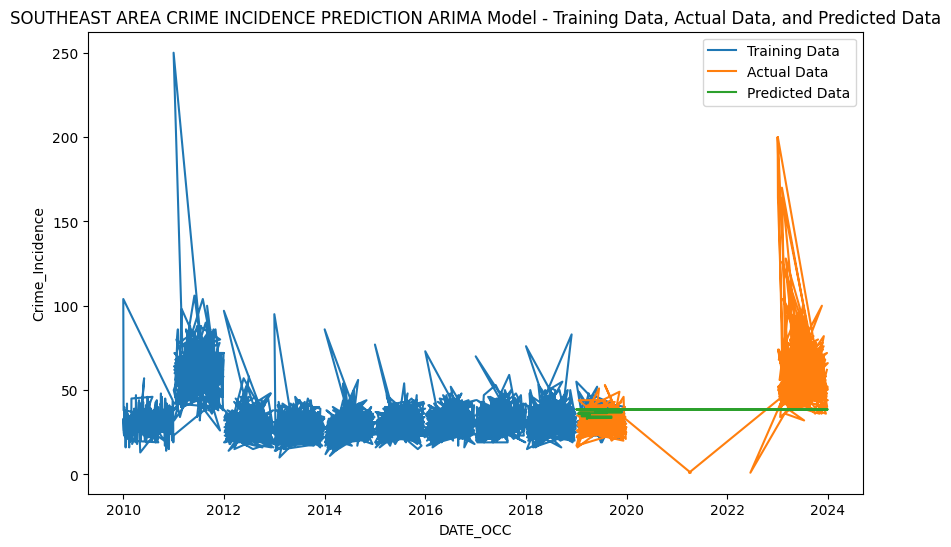

Root Mean Squared Error on Test Set: 35.79182520122989
RMSE: 35.79


In [42]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Southeast_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Southeast_dataset[:train_size]['Crime_Incidence'], Southeast_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Southeast_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Southeast_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Southeast_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('SOUTHEAST AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**7. ARIMA for Hollywood Area**

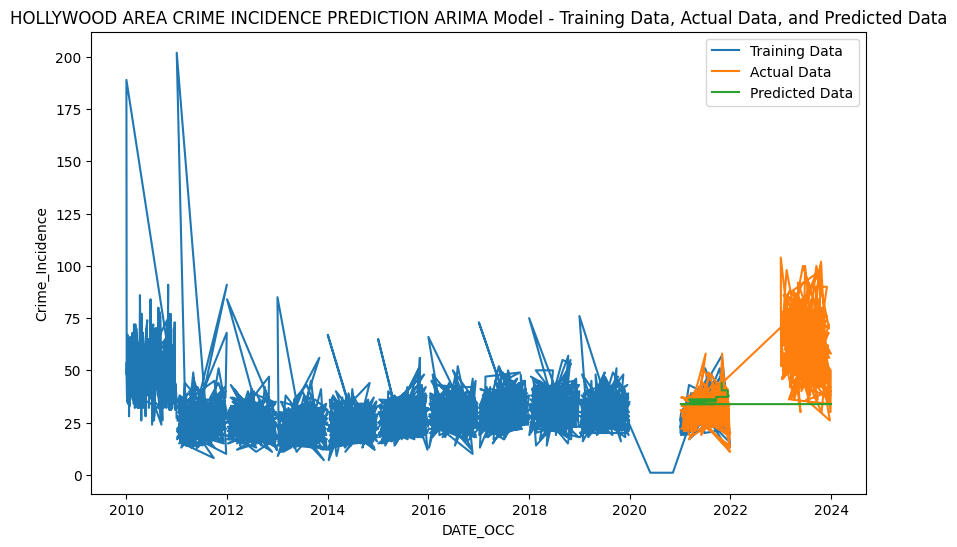

Root Mean Squared Error on Test Set: 30.077283997115448
RMSE: 30.08


In [46]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Hollywood_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Hollywood_dataset[:train_size]['Crime_Incidence'], Hollywood_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Hollywood_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Hollywood_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Hollywood_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('HOLLYWOOD AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**8. ARIMA for Northeast Area**

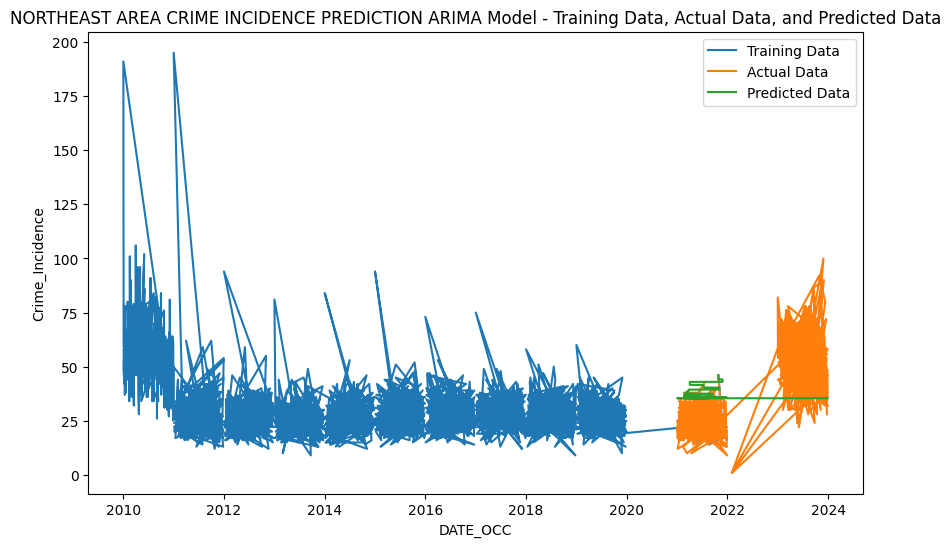

Root Mean Squared Error on Test Set: 20.78471554311238
RMSE: 20.78


In [47]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Northeast_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Northeast_dataset[:train_size]['Crime_Incidence'], Northeast_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Northeast_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Northeast_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Northeast_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('NORTHEAST AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**9. ARIMA for Van Nuys Area**

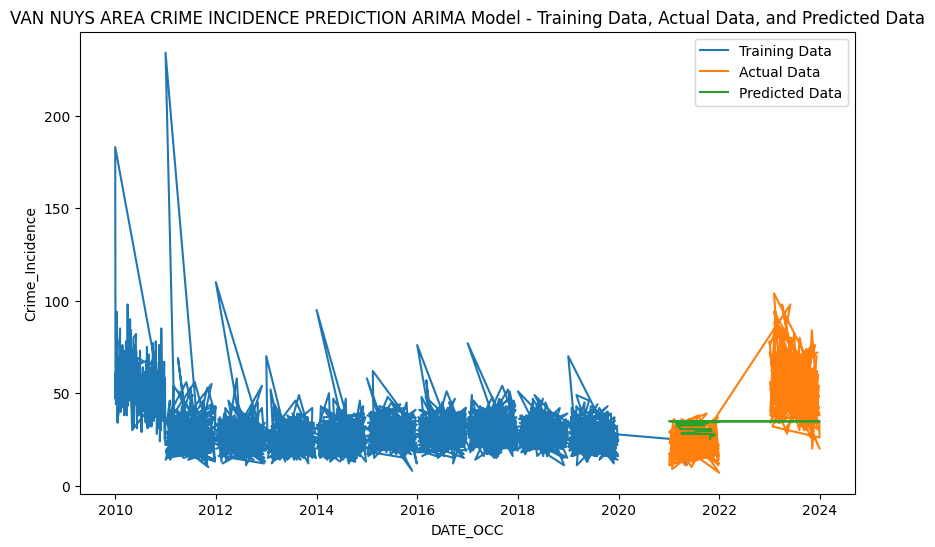

Root Mean Squared Error on Test Set: 22.449279652093097
RMSE: 22.45


In [48]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Van_Nuys_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Van_Nuys_dataset[:train_size]['Crime_Incidence'], Van_Nuys_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Van_Nuys_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Van_Nuys_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Van_Nuys_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('VAN NUYS AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**10. ARIMA for Newton Area**

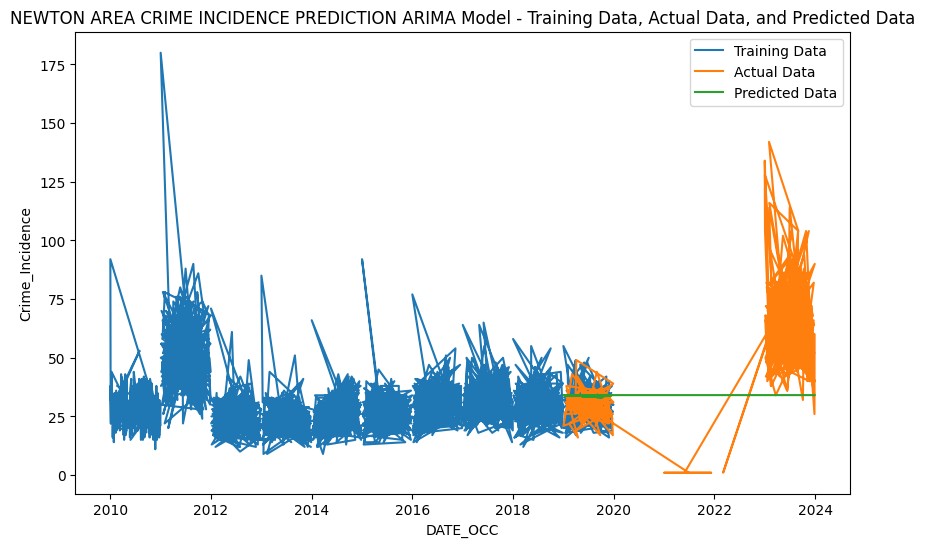

Root Mean Squared Error on Test Set: 36.63493108853757
RMSE: 36.63


In [49]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Newton_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Newton_dataset[:train_size]['Crime_Incidence'], Newton_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Newton_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Newton_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Newton_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('NEWTON AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**11. ARIMA for Mission Area**

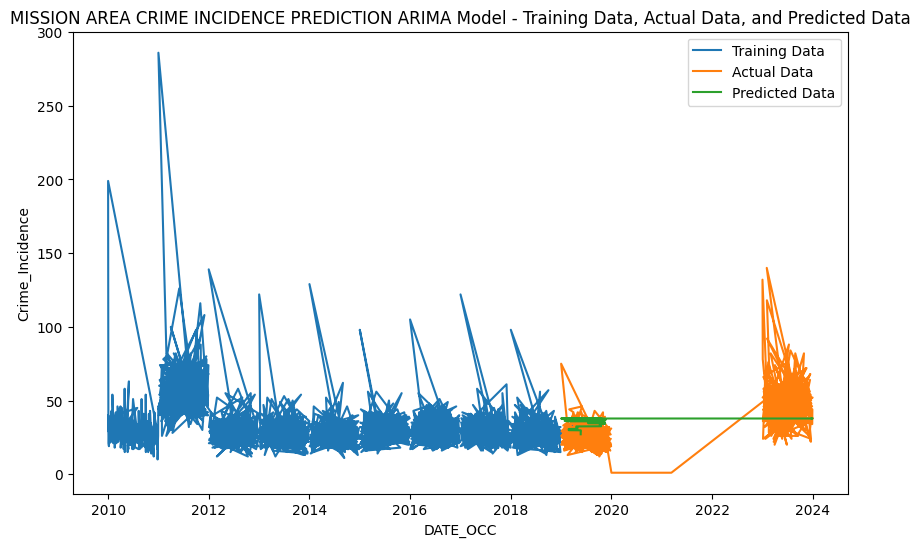

Root Mean Squared Error on Test Set: 19.863533488280666
RMSE: 19.86


In [50]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Mission_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Mission_dataset[:train_size]['Crime_Incidence'], Mission_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Mission_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Mission_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Mission_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('MISSION AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**12. ARIMA for Rampart Area**

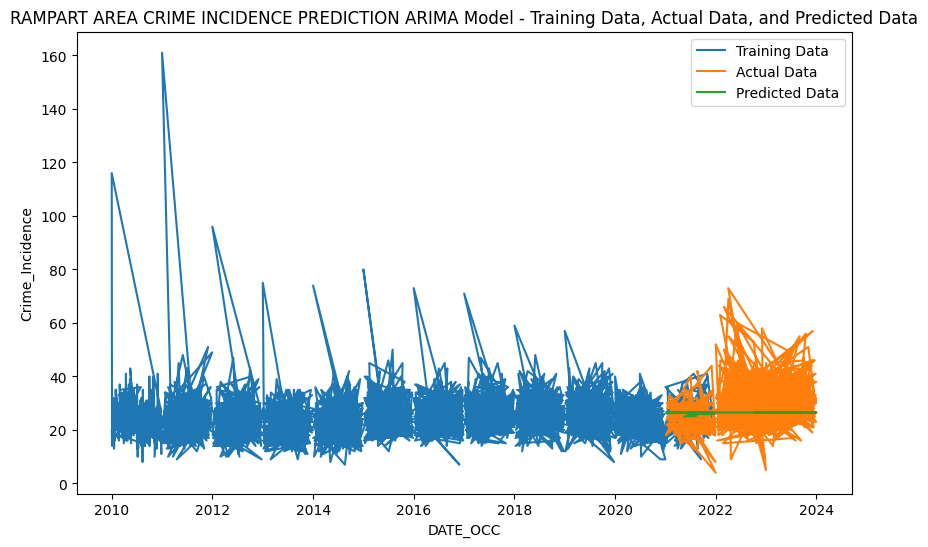

Root Mean Squared Error on Test Set: 10.165472364169865
RMSE: 10.17


In [51]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Rampart_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Rampart_dataset[:train_size]['Crime_Incidence'], Rampart_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Rampart_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Rampart_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Rampart_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('RAMPART AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**13. ARIMA for Wilshire Area**

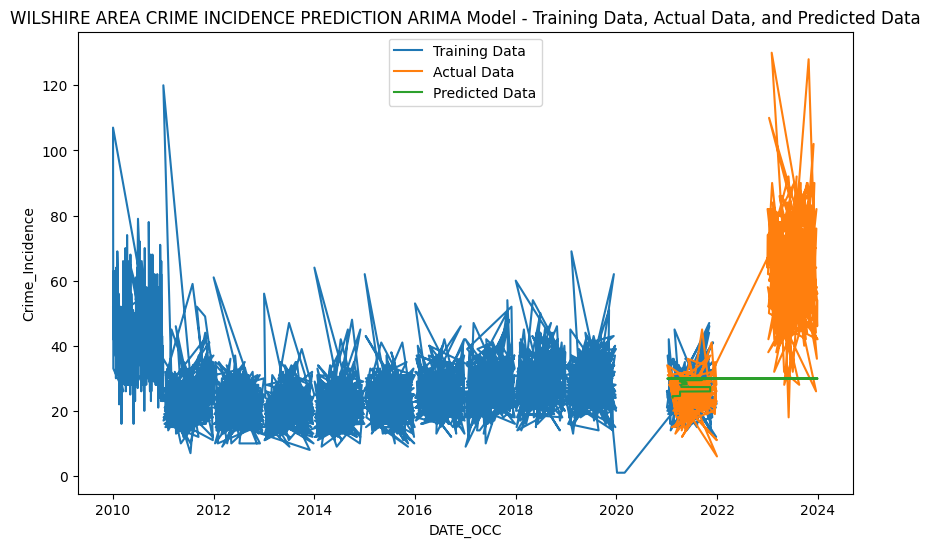

Root Mean Squared Error on Test Set: 37.02051095960565
RMSE: 37.02


In [52]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Wilshire_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Wilshire_dataset[:train_size]['Crime_Incidence'], Wilshire_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Wilshire_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Wilshire_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Wilshire_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('WILSHIRE AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**14. ARIMA for West LA Area**

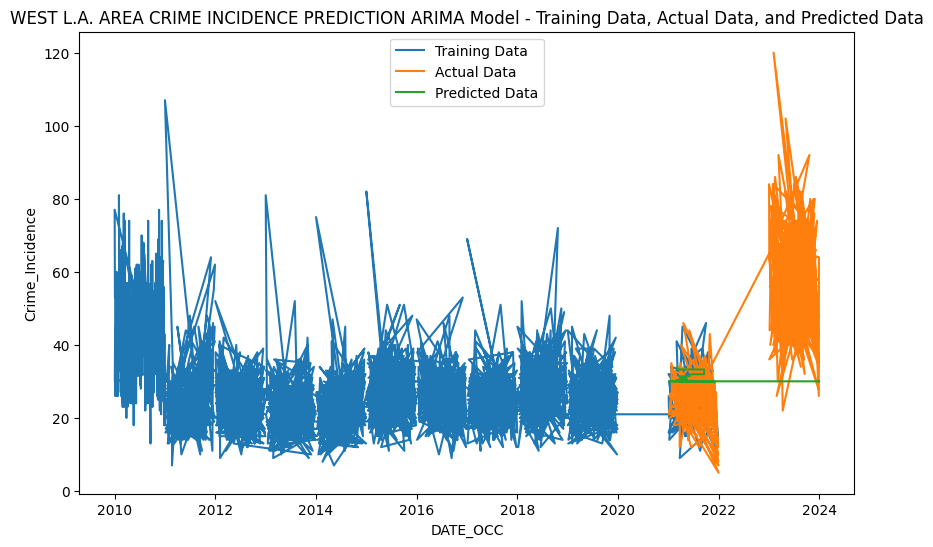

Root Mean Squared Error on Test Set: 29.566737148754896
RMSE: 29.57


In [53]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(West_LA_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = West_LA_dataset[:train_size]['Crime_Incidence'], West_LA_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(West_LA_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(West_LA_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(West_LA_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('WEST L.A. AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**15. ARIMA for West Valley Area**

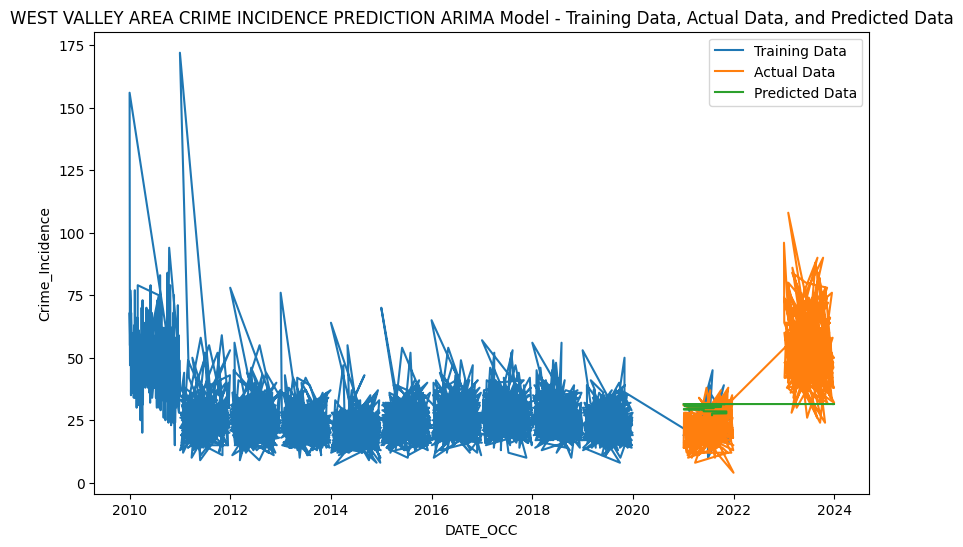

Root Mean Squared Error on Test Set: 25.215975122700495
RMSE: 25.22


In [54]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(West_Valley_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = West_Valley_dataset[:train_size]['Crime_Incidence'], West_Valley_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(West_Valley_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(West_Valley_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(West_Valley_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('WEST VALLEY AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**16. ARIMA for Olympic Area**

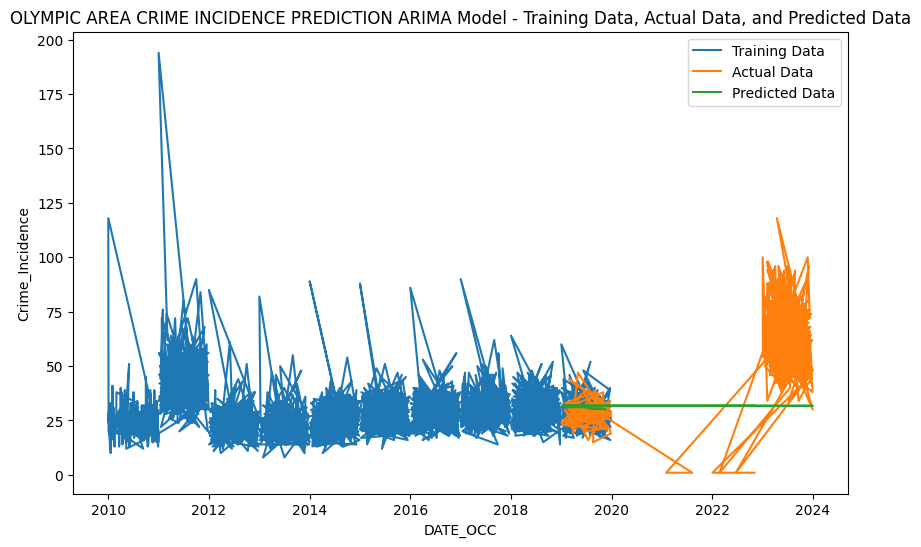

Root Mean Squared Error on Test Set: 35.404502775054375
RMSE: 35.40


In [55]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Olympic_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Olympic_dataset[:train_size]['Crime_Incidence'], Olympic_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Olympic_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Olympic_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Olympic_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('OLYMPIC AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**17. ARIMA for Topanga Area**

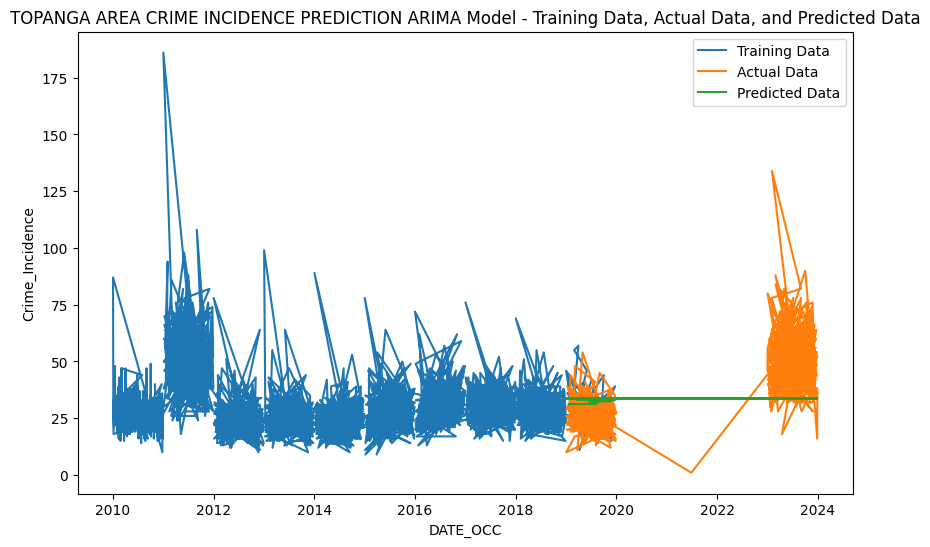

Root Mean Squared Error on Test Set: 22.31708397220118
RMSE: 22.32


In [56]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Topanga_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Topanga_dataset[:train_size]['Crime_Incidence'], Topanga_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Topanga_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Topanga_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Topanga_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('TOPANGA AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**18. ARIMA for Devonshire Area**

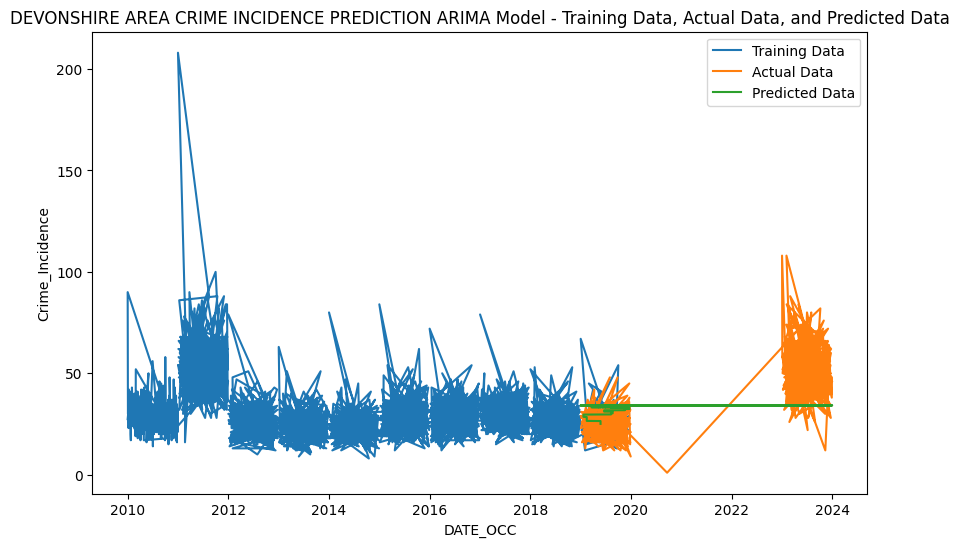

Root Mean Squared Error on Test Set: 21.985771106561906
RMSE: 21.99


In [57]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Devonshire_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Devonshire_dataset[:train_size]['Crime_Incidence'], Devonshire_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Devonshire_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Devonshire_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Devonshire_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('DEVONSHIRE AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**19. ARIMA for Harbor Area**

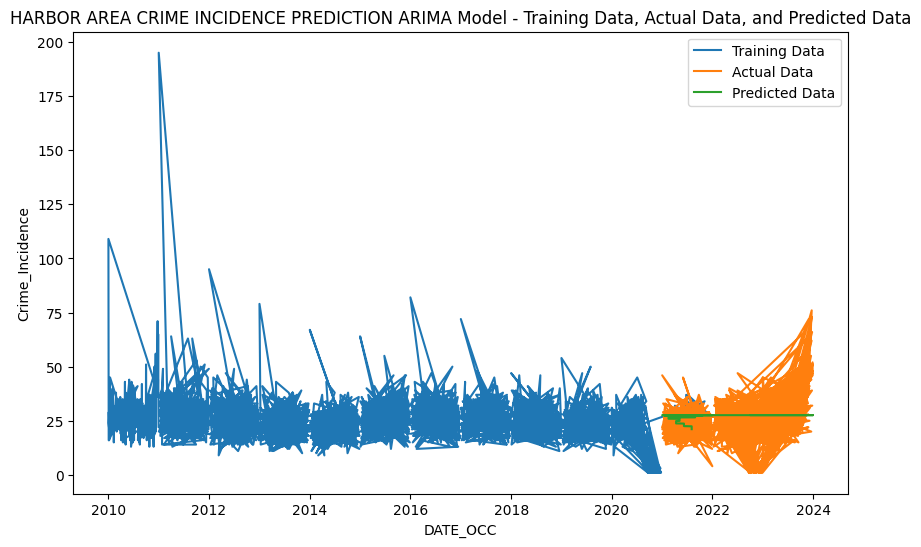

Root Mean Squared Error on Test Set: 10.710403630709408
RMSE: 10.71


In [58]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Harbor_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Harbor_dataset[:train_size]['Crime_Incidence'], Harbor_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Harbor_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Harbor_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Harbor_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('HARBOR AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**20. ARIMA for Hollenbeck Area**

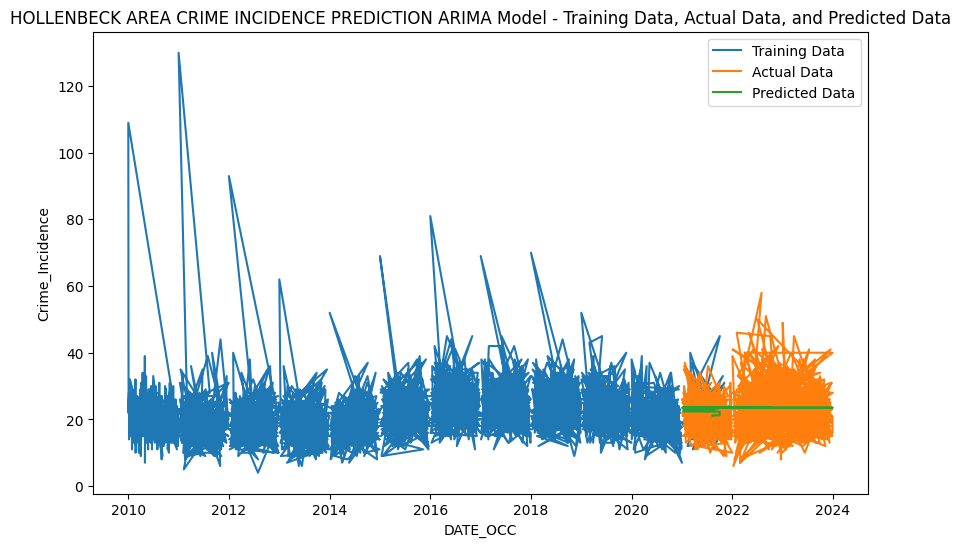

Root Mean Squared Error on Test Set: 7.047562281047359
RMSE: 7.05


In [60]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Hollenbeck_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Hollenbeck_dataset[:train_size]['Crime_Incidence'], Hollenbeck_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Hollenbeck_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Hollenbeck_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Hollenbeck_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('HOLLENBECK AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)

**21. ARIMA for Foothill Area**

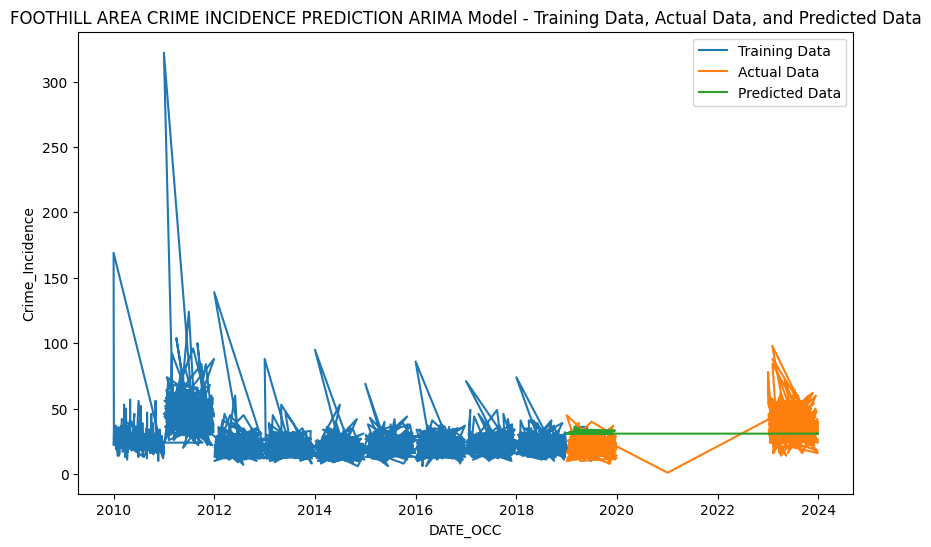

Root Mean Squared Error on Test Set: 14.60022647172687
RMSE: 14.60


In [61]:
# Function to fit ARIMA model and make predictions
def fit_arima(train_data, order):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

# Function to evaluate ARIMA model
def evaluate_arima(model_fit, test_data):
    predictions = model_fit.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# Split data into train and test sets
train_size = int(len(Foothill_dataset) * 0.8)  # Adjust the train size as needed
train_data, test_data = Foothill_dataset[:train_size]['Crime_Incidence'], Foothill_dataset[train_size:]['Crime_Incidence']

# Fit the ARIMA model with p=1, d=0, q=2 using the training data
order = (1, 0, 2)
model_fit = fit_arima(train_data, order)

# Evaluate the model on the test set
rmse, forecast = evaluate_arima(model_fit, test_data)

# Plot the results
plt.figure(figsize=(10, 6))

# Training Data
plt.plot(Foothill_dataset.index[:train_size], train_data, label='Training Data')

# Actual Data
plt.plot(Foothill_dataset.index[train_size:], test_data, label='Actual Data')

# Predicted Data
plt.plot(Foothill_dataset.index[train_size:], forecast, label='Predicted Data')

plt.xlabel('DATE_OCC')
plt.ylabel('Crime_Incidence')
plt.legend()
plt.title('FOOTHILL AREA CRIME INCIDENCE PREDICTION ARIMA Model - Training Data, Actual Data, and Predicted Data')
plt.show()
# Print the Root Mean Squared Error (RMSE) on the test set
print(f'Root Mean Squared Error on Test Set: {rmse}')
print('RMSE: %.2f' % rmse)